# Finding the Higgs Boson

## Import packages

In [ ]:
# Packages that may need to be installed
!pip install iminuit
!pip install mplhep
!pip install seaborn

In [ ]:
import copy
import logging
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import seaborn as sns
from iminuit import Minuit
from functools import partial
logging.getLogger("iminuit").setLevel(logging.WARNING)
plt.style.use(hep.style.CMS)

## Introduction

This exercise is based on a real problem in particle physics. The objective is to identify the Higgs boson using simulated data that replicates what is expected to be observed by the CMS experiment at the Large Hadron Collider (LHC) at CERN. The LHC collides protons at extremely high energies. CMS collects roughly 1000 proton collision events per second, so there is a lot of data to play with!

To predict what we should observe in the CMS detector, physicists generate Monte Carlo (MC) simulations, datasets whose distributions model the expected outcomes of various physical processes. The specific task here is to distinguish a signal (S) of Higgs bosons decaying into $\tau$ leptons from a much larger background (B) of $Z$ bosons decaying into $\tau$ leptons. Diagrams of the two processes are shown below.

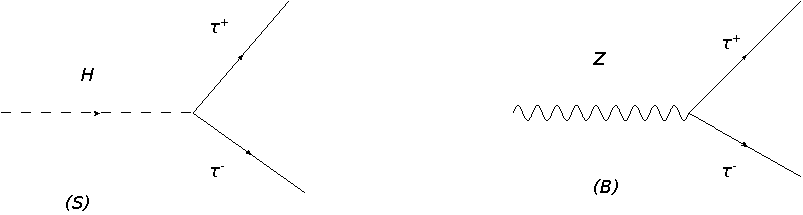

The $\tau$ leptons can then decay hadronically (h) or leptonically - so either an electron (e) or a muon ($\mu$) as shown below:

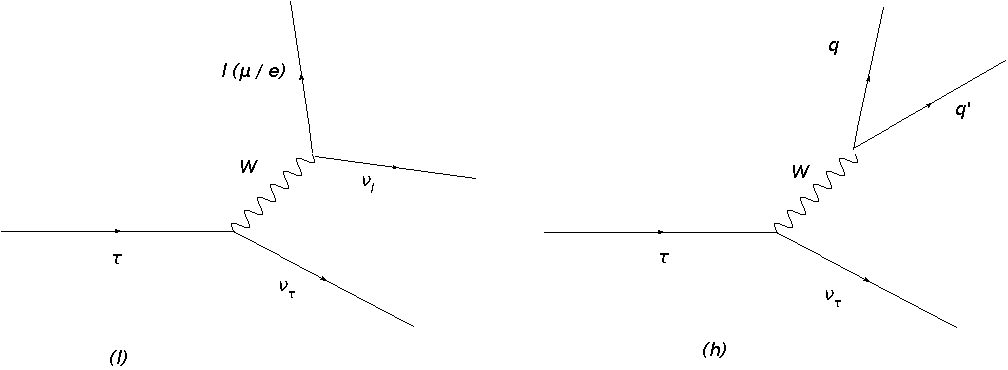

Now the Z boson has a mass of ~90 GeV and the Higgs boson a mass of ~125 GeV, so naively you would think that this would be easy, as you could just reconstruct all the particles and find the invariant mass. However, the problem is that we cannot reconstruct any of the neutrinos ($\nu$), so we have to use other variables as well.

There is a slight complication in that the Higgs can be produced in different ways. The most likely two being gluon fusion (ggH) and vector boson fusion (VBF). With ggH happening about 10 the rate of VBF, however VBF events have some topological structures that might help to identify them. The processes are shown below:

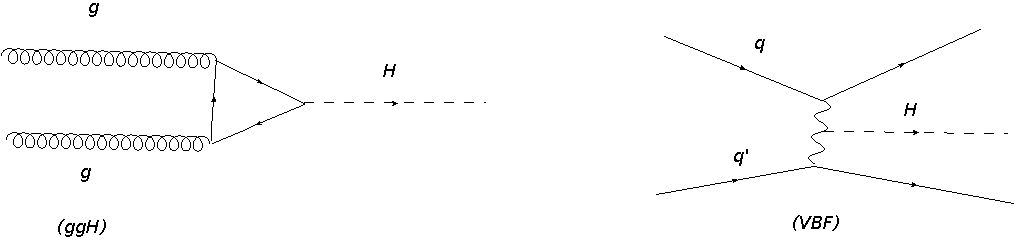


### About 2000 Z bosons are produced for every Higgs boson that is produced ###

## Datasets

You are given simulated MC datasets separated by decay channels:  where one $\tau$ has decayed to an electron and the other hadronically (et), where one $\tau$ has decayed to a $\mu$ and the other hadronically (mt), and where both have decayed hadronically (tt). 

They are also separated by process: Z bosons, Higgs from ggH and Higgs from VBF. 

In each of these datasets, there are a series of event variables which are explained below.


In [ ]:
channels = ["et","mt","tt"]
processes = ["Z","ggH","VBF"]

dataset = {}
for channel in channels:
    dataset[channel] = {}
    for process in processes:
        url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
        dataset[channel][process] = pd.read_pickle(url)

An example of the tt channel DY events are shown below.

In [ ]:
display(dataset["mt"]["VBF"])

### Variables definitions
If a variable shown below ends with {1,2}, this means that the variable exists for both the tau decay products 1 and 2. 1 refers to the leading transverse momentum hadronic tau in tt channel and the electron or muon in the et or mt channel. 2 refers to the subleading transverse momentum hadronic tau in tt channel and the hadronic tau in the et and mt channel. Any variable that takes the value -9999 is undefined for that event.

- dR: Distance between the two tau decay products.
- dijetpt: Total transverse momentum of the two highest transverse momentum jets in the event.
- dphi: The angle phi between the two tau decay products.
- eta_{1,2}: The detector eta of the tau decay products.
- jdeta: The eta between the two highest transverse momentum jets in the event.
- jpt_1: The transverse momentum of the leading transverse momentum jet in the event.
- jpt_2: The transverse momentum of the subleading transverse momentum jet in the event.
- m_vis: The reconstructed mass of the visibile ditau decay products.
- met: The missing transverse energy in the event.
- met_dphi_{1,2}: The angle phi between the met and the tau decay product.
- mjj: The reconstructed mass of the two highest transverse momentum jets in the event.
- mt_{1,2}: The transverse mass between the met and the tau decay product.
- mt_lep: The transverse mass between the two tau decay products.
- mt_tot: The sum in quadrature of mt_1, mt_2 and mt_lep.
- mva_dm_{1,2}: The predicted decay mode of the hadronic tau (1 only available for tt channel).
- n_deepbjets: The number of b tagged jets in the event.
- n_jets: The number of jets in the events.
- pt_{1,2}: The transverse momentum of the tau decay product.
- pt_tt: The reconstructed ditau + met transverse momentum.
- pt_vis: The reconstructed ditau transverse momentum.
- q_{1,2}: The charge of the tau decay product.
- svfit_mass: A likelihood reconstruction of the ditau mass.

## Task

We want you to use simulated events to try to optimise a search for the signal Higgs bosons. To do this, you will need to attempt to separate the signal Higgs boson events from the background Z boson events. Your assignment is to produce a binning of the dataset that provides the most precise binned likelihood fit for the rate of the signal. The bins should be chosen by using the output of a machine learning algorithm.

Things you may want to try:
- Try both binary (S vs B) and multiclass (Z, ggH, VBF) classifiers.
- Try different machine learning classification models.
- Try training classifiers both on the decay channels (et, mt, tt) individually and merged into one dataset.
- Try building the histograms from the binary signal classifier score.
- Try building 2D histograms from the multiclass output scores.

## Classical solution

It is common in particle physics to compare the performance of a machine learning algorithm to that of a classical algorithm. This will act as a baseline solution, to show the improvement you can get with machine learning.

Here we show an example of using a binned m_vis histogram to measure the precision using a binned likelihood fit, where all channels are merged together.

First, we build the histograms.

In [ ]:
bins = np.linspace(50,200,num=51)
variable = "m_vis"

combined_channels_dataset = {}
histograms = {}
for proc in processes:
  combined_channels_dataset[proc] = pd.concat([dataset[ch][proc] for ch in channels])
  histograms[proc] = np.histogram(combined_channels_dataset[proc].loc[:,variable], bins=bins)[0]

The current length of the simulated datasets do not represent the number of events expected. Therefore, we scale them to what is expected. In your studies, you should use the same function.

In [ ]:
def scale_histograms_to_correct_yield(histograms):
  """
  Scale histograms for different processes to the expected yields.
  
  Args:
    histograms (dict): Dictionary of histograms with keys "Z", "ggH", "VBF".
                       Each value is a NumPy array representing bin counts.

  Returns:
    dict: The input dictionary with histograms scaled to the expected yields.
  """
  for proc in ["Z","ggH","VBF"]:
    histograms[proc] = histograms[proc].astype(float)
  histograms["Z"] *= 8.4
  histograms["ggH"] *= 0.034
  histograms["VBF"] *= 0.011
  return histograms

In [ ]:
scaled_histograms = scale_histograms_to_correct_yield(histograms)

We can then plot the histograms. Here we also scale up the signal (just for the plot) so it is visible.

In [ ]:
def plot_histograms(hist, bins, x_label, title_right=None, scale_signal=10):
  """
  Plot stacked histograms for multiple processes with optional signal scaling.

  Args:
    hist (dict): Dictionary of histograms with process names as keys and
                 NumPy arrays of bin counts as values.
    bins (array-like): Bin edges for the histograms.
    x_label (str): Label for the x-axis.
    title_right (str, optional): Text displayed in the top-right corner of the plot.
    scale_signal (float, optional): Factor to scale signal histograms ("ggH" and "VBF")
                                    for better visibility on the plot. Set to None to disable.
  """
  hist = copy.deepcopy(hist)
  if scale_signal is not None:
    for sig_proc in ["ggH","VBF"]:
      hist[f"{scale_signal} x {sig_proc}"] = scale_signal*hist[sig_proc]
      del hist[sig_proc]

  if title_right is None:
    title_right = ""

  fig, ax = plt.subplots(1, 1, figsize=[8,6])
  rgb_palette = sns.color_palette("Set2", len(hist.keys()))
  step_edges = np.append(bins, 2*bins[-1]-bins[-2])

  for ind, (k, v) in enumerate(hist.items()):
    if ind == 0: bottom = None
    ax.bar(
      bins[:-1],
      v,
      bottom=bottom,
      width=np.diff(bins),
      align='edge',
      alpha=1.0,
      label=k,
      color=tuple(x for x in rgb_palette[ind]),
      edgecolor=None
    )
    if bottom is None:
      bottom = v*1.0
    else:
      bottom += v

    step_histvals = np.append(np.insert(bottom,0,0.0),0.0)
    ax.step(step_edges, step_histvals, color='black')

  ax.text(1.0, 1.0, title_right, verticalalignment='bottom', horizontalalignment='right',
          transform=ax.transAxes, fontsize=22)
  plt.ylim(10, np.max(bottom)*2)
  plt.xlim(bins[0], bins[-1])
  plt.xlabel(x_label)
  plt.ylabel("Events")
  plt.yscale('log')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
plot_histograms(scaled_histograms, bins, variable)

One thing we must check before doing a binned likelihood fit, is that we have enough events in every bin. If this steps is not passed, make the bins used coarser.

In [ ]:
def check_events_numbers(histograms, threshold=10):
  """
  Check that each bin in the summed histograms has at least a minimum number of events.

  Args:
    histograms (dict): Dictionary of histograms with process names as keys and
                       NumPy arrays of bin counts as values.
    threshold (int, optional): Minimum number of events required in each bin. Default is 10.

  Raises:
    ValueError: If any bin in the summed histogram has fewer than `threshold` events.
  """
  summed_histogram = np.sum(list(histograms.values()), axis=0)
  if (summed_histogram < threshold).any():
    raise ValueError("Not enough events in one or more of the histogram bins")

In [ ]:
check_events_numbers(scaled_histograms)

We have two choices for the type of fit.

The first is a fit for an inclusive signal strength modifier (that scales both the rate of ggH and VBF together).

The second is a fit for the signal strength modifiers mu_ggH (that scales the rate of the ggH process) and mu_VBF (that scales the rate of the VBF process) simultaneously.

As we are fitting for the expected values, the fit should return signal strength modifiers of approximately 1 with some uncertainty.

The metric we are interested in is the precision of the measurement of each signal strength modifier. This tells us to what precision we can measure the rate of that process. You want the percentage to be as small as possible.

We build two types of likelihood functions and we perform the fit with minuit.

In [ ]:
def nll_merge(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) assuming a single signal strength parameter
  for both ggH and VBF processes combined.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu (float): Signal strength multiplier applied to ggH and VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu * (expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]))
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))


def nll_separate(expected_counts_per_process, mu_ggH, mu_VBF):
  """
  Compute the negative log-likelihood (NLL) using separate signal strength parameters
  for ggH and VBF processes.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu_ggH (float): Signal strength multiplier for ggH.
    mu_VBF (float): Signal strength multiplier for VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu_ggH * expected_counts_per_process["ggH"]) + (mu_VBF * expected_counts_per_process["VBF"])
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

In [ ]:
nll = partial(nll_merge, scaled_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

In [ ]:
nll = partial(nll_separate, scaled_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

This gives us a precision of ~10% on the total signal rate, and a precision of ~57% for ggH and ~490% for VBF.

This example is very basic and you get very poor performance for VBF. If you look closely at the simulated data you will see that VBF is more prominent when n_jets >= 2, jdeta > 2.5 and mjj > 200. Therefore, we define two orthogonal splits of the data, one that targets VBF events and one that targets ggH. We now apply all the same steps as we did in the previous example.

In [ ]:
# Make histograms
vbf_like_query = "(n_jets >= 2) & (jdeta > 2.5) & (mjj > 200)"
variable = "m_vis"
vbf_like_bins, ggH_like_bins = np.linspace(50, 200, 21), np.linspace(50, 200, 51)

vbf_like_dataset = {p: combined_channels_dataset[p].query(vbf_like_query) for p in processes}
ggH_like_dataset = {p: combined_channels_dataset[p].query(f"not ({vbf_like_query})") for p in processes}

vbf_like_histograms = {p: np.histogram(vbf_like_dataset[p][variable], bins=vbf_like_bins)[0] for p in processes}
ggH_like_histograms = {p: np.histogram(ggH_like_dataset[p][variable], bins=ggH_like_bins)[0] for p in processes}

In [ ]:
# Scale histograms
scaled_vbf_like_histograms = scale_histograms_to_correct_yield(vbf_like_histograms)
scaled_ggH_like_histograms = scale_histograms_to_correct_yield(ggH_like_histograms)

# Check binning is ok
check_events_numbers(scaled_vbf_like_histograms)
check_events_numbers(scaled_ggH_like_histograms)

In [ ]:
# Plot histograms
plot_histograms(scaled_vbf_like_histograms, vbf_like_bins, variable, title_right="Targeting VBF")
plot_histograms(scaled_ggH_like_histograms, ggH_like_bins, variable, title_right="Targeting ggH")

You can see that VBF is now visible in the plot! This is a good sign, we can now test the binning by performing the fits. As the histograms are from orthogonal splits in the data, we can concatenate the histograms for the binned likelihood fit.

In [ ]:
# Concatenate histograms
concatenated_histograms = {proc: np.concatenate([scaled_vbf_like_histograms[proc], scaled_ggH_like_histograms[proc]]) for proc in processes}

In [ ]:
# Run fit for mu
nll = partial(nll_merge, concatenated_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

In [ ]:
# Run fit for mu_ggH and mu_VBF
nll = partial(nll_separate, concatenated_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

This now does much better for ggH (57% -> 12%) and VBF (490% -> 35%). The multidimensionality of the dataset is important in optimising the Higgs boson search! But this is just a classical example that uses more than one variable. You can do much better with machine learning.

The CMS published analysis managed a statistical precision of:
   * mu_ggH: 9%
   * mu_VBF: 18%
   * mu: 6%

See if you can beat it!

## Your work

In [1]:
#Imports
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import seaborn as sns
from iminuit import Minuit
from functools import partial
logging.getLogger("iminuit").setLevel(logging.WARNING)
plt.style.use(hep.style.CMS)

In [2]:
# Creating lists for dict keys
channels = ["et","mt","tt"]
processes = ["Z","ggH","VBF"]

# Initialising the dataset dict with the data
dataset = {}
for channel in channels:
    dataset[channel] = {}
    for process in processes:
        url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
        df = pd.read_pickle(url)
        df.replace(-9999, np.nan, inplace=True)             # Replace -9999 with NaN for native xgboost handling
        dataset[channel][process] = df

In [3]:
def plot_binary_hist(S_hist, B_hist, bins, channel):
    """
    Plot a histogram for binary probability scores.
    
    Args:
        S_hist (array-like): Probability scores for signal events in the test set.
        B_hist (array-like): Probability scores for background events in the test set.
        bins (array-like): Bin edges for the histogram.
        channel (str): Channel name(s) to be plotted ['et', 'mt', 'tt', or 'all'].
    """
    if channel=='all':          # Channel title formatting
        title = "Histogram for All Channels"
    else:
        title = f"Histogram for {channel} Channel"
    fig, ax = plt.subplots(1, 1, figsize=[12,10], tight_layout=True)
    ax.hist(S_hist, bins=bins, alpha=0.3, label='Signal (ggH + VBF)', color='blue')
    ax.hist(B_hist, bins=bins, alpha=0.3, label='Background (Z)', color='red')
    ax.set_title(title)
    ax.set_xlabel(r'Probability Score $p_S$')
    ax.set_ylabel('Events')
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1, None)
    ax.set_xlim(0,1)
    plt.show()

In [ ]:
def binary_classification(dataset, channel, bins):
    """
    Trains an XGBoost binary classifier to distinguish between signal and background processes, building histograms
    of classifier-derived probability scores to fit signal strength parameters (mu) using a Poisson NLL.

    Parameters:
        dataset (dict): Dictionary with process names and channel names as keys and corresponding DataFrames as values.
        channel (str): Channel name(s) to be analyzed ['et', 'mt', 'tt', 'all'].
        bins (int): Bin edges for the histogram..
        
    Returns:
        sig_score (np.ndarray): Probability scores for signal events in the test set.
        bkg_score (np.ndarray): Probability scores for background events in the test set.
        mu_mean (float): Estimated signal strength parameter.
        mu_error (float): Uncertainty in the estimated signal strength parameter.
    """
    
    # Step 1: Determining appropriate channel for analysis
    print("[1/8] Channel Selection")
    if channel=='all':
        channels = ["et","mt","tt"]
    else:
        channels = [channel]
    
    # Step 2: Concatenating data of all the process for specified channels
    print("[2/8] Data Concatenation")
    all_dfs = []
    for channel in channels:
        for process in dataset[channel]:
            df = dataset[channel][process].copy()
            df['process'] = process                     #Adding process column for cleaner identification
            all_dfs.append(df)
    data = pd.concat(all_dfs, ignore_index=True)

    # Step 3: Creating features and the target of the classification
    print("[3/8] Target Creation")
    data['y'] = np.where(data['process'].isin(['ggH', 'VBF']), 1, 0)
    X = data.drop(columns=['process', 'y'])
    y = data['y']
    
    # Step 4: Splitting data into training and testing sets
    print("[4/8] Train and Test Data Splitting")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Step 5: Training XGBoost binary classifier on training data
    print("[5/8] Training Classifier")
    model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.125,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train)
    
    
    # Step 6: Predicting probabilities on test set and separating scores for background and signal events
    print("[6/8] Predicting Probabilities")
    prob_score = model.predict_proba(X_test)[:, 1]
    sig_score = prob_score[y_test==1]
    bkg_score = prob_score[y_test==0]
    
    # Step 7: Creating histograms of the scores and a dictionary of expected counts per process
    print("[7/8] Creating Histograms and Expected Counts Dictionary")
    hist_Z, _   = np.histogram(bkg_score,   bins=bins)
    hist_H, _   = np.histogram(sig_score,   bins=bins)
    expected_counts_per_process = {
        "Z": hist_Z,
        "H": hist_H
    }
    
    # Step 8: Fitting for the signal strength parameter (mu) using the nll_merge function
    print("[8/8] Fitting the Signal Strength Parameter (mu)")
    nll = partial(nll_merge, expected_counts_per_process)
    m = Minuit(nll, mu=1.0)
    m.migrad()
    mu_mean = np.round(m.values['mu'], 4)
    mu_error = np.round(m.errors['mu'], 4)
    
    return sig_score, bkg_score, mu_mean, mu_error 

In [5]:
# Defining bin edges for histogramming probability scores to prevent null bins
bins = np.linspace(0, 1, 21)

In [8]:
# Running binary classification for all channels
S_total, B_total, mu_total, mu_total_err = binary_classification(dataset, channel='all', bins=bins)

[1/8] Channel Selection
[2/8] Data Concatenation
[3/8] Target Creation
[4/8] Train and Test Data Splitting
[5/8] Training Classifier
[6/8] Predicting Probabilities
[7/8] Creating Histograms and Expected Counts Dictionary
[8/8] Fitting for Signal Strength Parameter (mu)


mu = 1.0 ± 0.0059


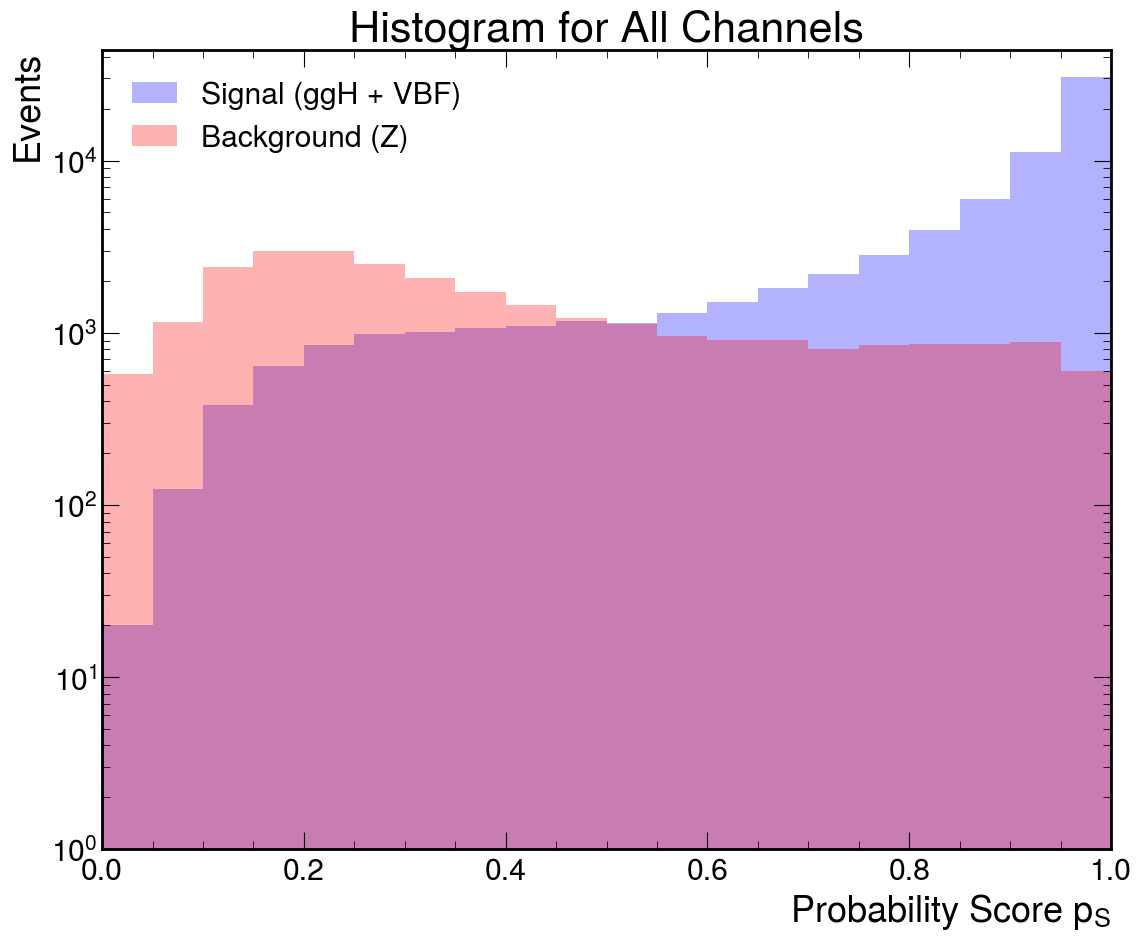

In [9]:
print(f"mu = {mu_total} ± {mu_total_err}")                      # Printing mu with uncertainty for all channels
plot_binary_hist(S_total, B_total, bins=bins, channel='all')    # Plotting probability histogram for all channels

In [10]:
# Running binary classification for et channel
S_et, B_et, mu_et, mu_et_err = binary_classification(dataset, channel='et', bins=bins)

[1/8] Channel Selection
[2/8] Data Concatenation
[3/8] Target Creation
[4/8] Train and Test Data Splitting
[5/8] Training Classifier
[6/8] Predicting Probabilities
[7/8] Creating Histograms and Expected Counts Dictionary
[8/8] Fitting for Signal Strength Parameter (mu)


mu (et) = 1.0 ± 0.0191


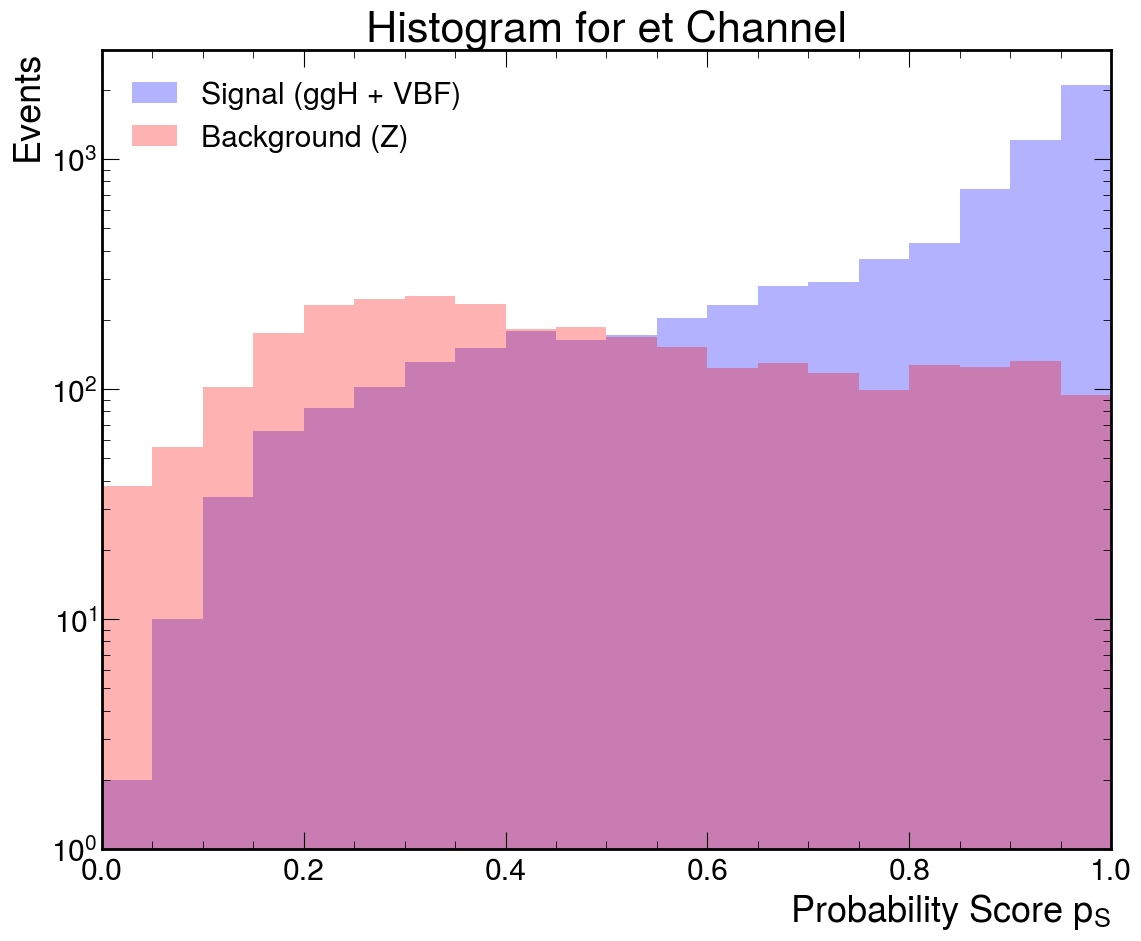

In [11]:
print(f"mu (et) = {mu_et} ± {mu_et_err}")               # Printing mu with uncertainty for et channel
plot_binary_hist(S_et, B_et, bins=bins, channel='et')   # Plotting probability histogram for et channel

In [12]:
# Running binary classification for mt channel
S_tt, B_tt, mu_tt, mu_tt_err = binary_classification(dataset, channel='tt', bins=bins)

[1/8] Channel Selection
[2/8] Data Concatenation
[3/8] Target Creation
[4/8] Train and Test Data Splitting
[5/8] Training Classifier
[6/8] Predicting Probabilities
[7/8] Creating Histograms and Expected Counts Dictionary
[8/8] Fitting for Signal Strength Parameter (mu)


mu (tt) = 1.0 ± 0.0097


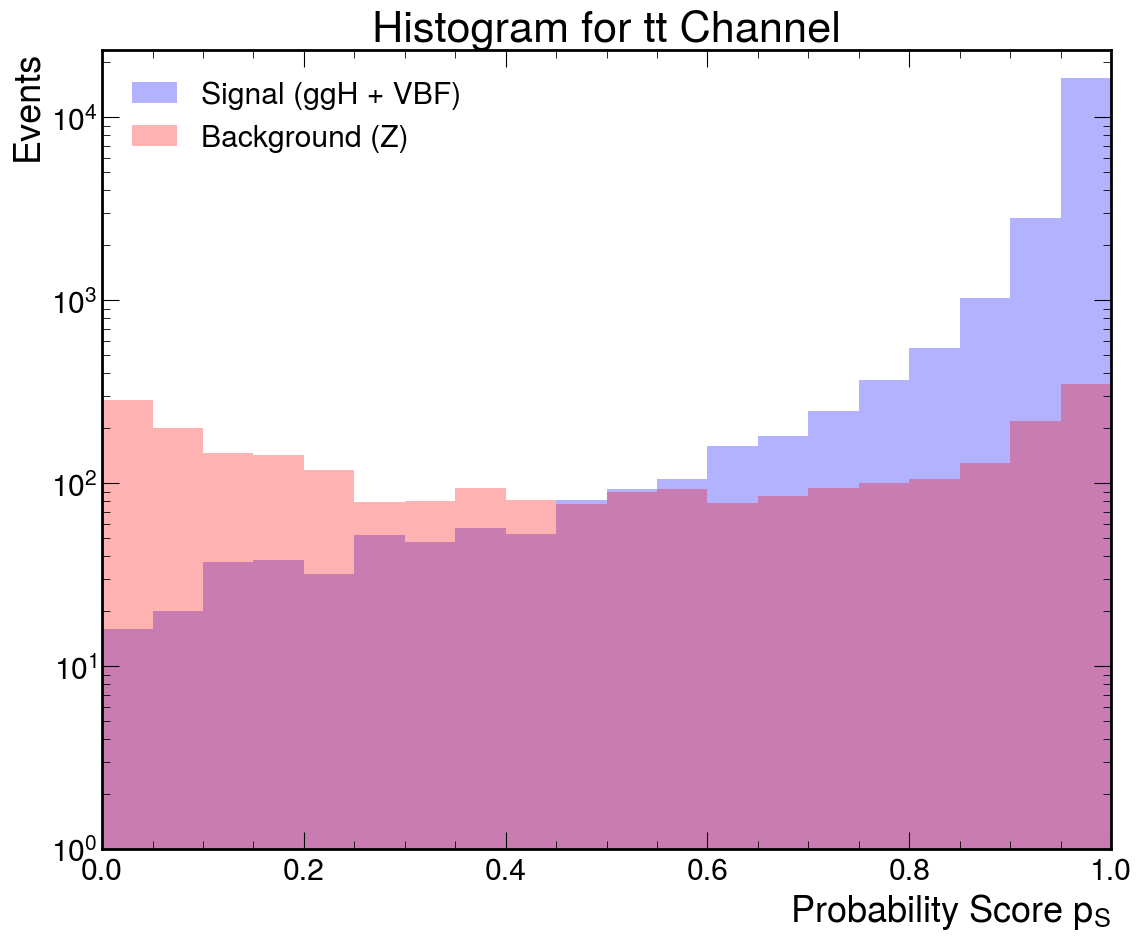

In [13]:
print(f"mu (tt) = {mu_tt} ± {mu_tt_err}")               # Printing mu with uncertainty for tt channel
plot_binary_hist(S_tt, B_tt, bins=bins, channel='tt')   # Plotting probability histogram for tt channel

In [14]:
# Running binary classification for mt channel
S_mt, B_mt, mu_mt, mu_mt_err = binary_classification(dataset, channel='mt', bins=bins)

[1/8] Channel Selection
[2/8] Data Concatenation
[3/8] Target Creation
[4/8] Train and Test Data Splitting
[5/8] Training Classifier
[6/8] Predicting Probabilities
[7/8] Creating Histograms and Expected Counts Dictionary
[8/8] Fitting for Signal Strength Parameter (mu)


mu (mt) = 1.0 ± 0.0079


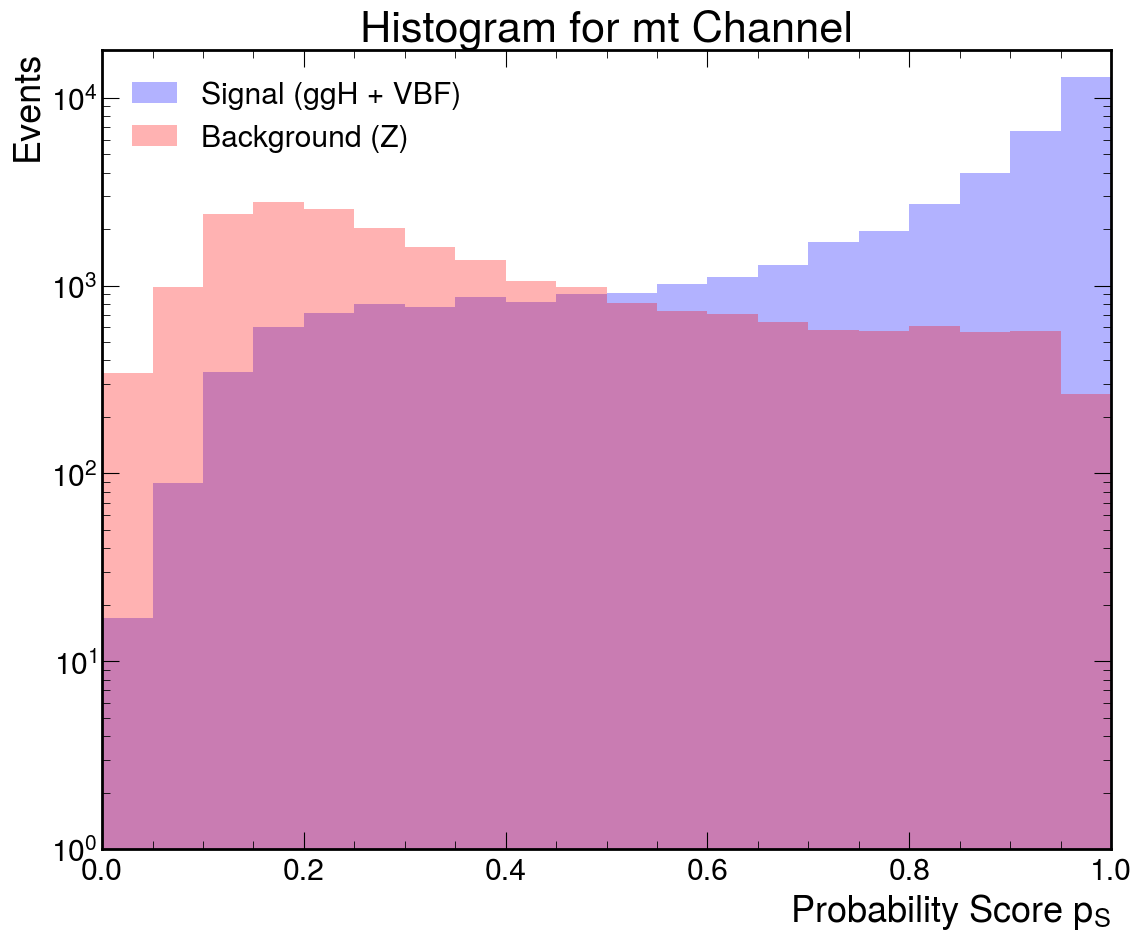

In [15]:
print(f"mu (mt) = {mu_mt} ± {mu_mt_err}")
plot_binary_hist(S_mt, B_mt, bins=bins, channel='mt')

# BREAK

In [25]:
def plot_multiclass_hist(Z_hist, ggH_hist, VBF_hist, bins, channel):
    """
    Plot a histogram for multiclass probability scores.
    
    Args:
        Z_hist (array-like): Probability scores for Z events in the test set.
        ggH_hist (array-like): Probability scores for ggH events in the test set.
        VBF_hist (array-like): Probability scores for VBF events in the test set.
        bins (array-like): Bin edges for the histogram.
        channel (str): Channel name(s) to be plotted ['et', 'mt', 'tt', or 'all'].
    """
    if channel=='all':          # Channel title formatting
        title = "Histogram for All Channels"
    else:
        title = f"Histogram for {channel} Channel"
    fig, ax = plt.subplots(1, 1, figsize=[12,10], tight_layout=True)
    ax.hist(Z_hist, bins=bins, alpha=0.5, label='Z')
    ax.hist(ggH_hist, bins=bins, alpha=0.5, label='ggH')
    ax.hist(VBF_hist, bins=bins, alpha=0.5, label='VBF')
    ax.set_title(title)
    ax.set_xlabel(r'Probability Score $p_S$')
    ax.set_ylabel('Events')
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1, None)
    ax.set_xlim(0,1)
    plt.show()

In [24]:
def plot_multiclass_hist2D(scores, channel, bins):
    """
    
    """
    
    if channel=='all':
        title = "2-D Scatter and Histogram for All Channels"
    else:
        title = f"2-D Scatter and Histogram for {channel} Channel"
    fig, ax = plt.subplots(2,2, figsize=(12,10), gridspec_kw=dict(height_ratios=[1,3], width_ratios=[3,1]))
    fig.delaxes(ax[0,1])
    for process in scores:
        ax[1,0].scatter(scores[process]['ggH'], scores[process]['VBF'], label=process, s=1)
        ax[0,0].hist(scores[process]['ggH'], bins=bins, alpha=0.5)
        ax[1,1].hist(scores[process]['VBF'], bins=bins, alpha=0.5, orientation='horizontal')
    ax[1,0].set_xlabel(r'Probability Score $p_{ggH}$')
    ax[1,0].set_ylabel(r'Probability Score $p_{VBF}$')
    ax[1,0].legend(markerscale=5)
    ax[0,0].tick_params(labelbottom=False)
    ax[1,1].tick_params(labelleft=False)
    ax[0,0].set_yscale('log')
    ax[1,1].set_xscale('log')
    ax[0,0].set_ylabel('Events')
    ax[1,1].set_xlabel('Events')
    ax[0,0].set_xlim(0,1)
    ax[1,1].set_ylim(0,1)
    ax[1,0].set_xlim(0,1)
    ax[1,0].set_ylim(0,1)
    fig.suptitle(title)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.975)
    plt.show()
    

In [ ]:
def multiclass_classification(dataset, channel, bins):
    """
    Trains an XGBoost multiclass classifier to distinguish between Z, ggH and VBF processes, building histograms
    of classifier-derived probability scores to fit signal strength parameters for signal as well as individual 
    signal channels (mu_S, mu_ggH, and mu_VBF) using a Poisson NLL.

    Parameters:
        dataset (dict): Dictionary with process names and channel names as keys and corresponding DataFrames as values.
        channel (str): Channel name(s) to be analyzed ['et', 'mt', 'tt', 'all'].
        bins (int): Bin edges for the histogram.
        
    Returns:
        scores (dict): Dictionary of probability scores keyed by process ['Z', 'ggH', 'VBF'] and 
        signal names ['S', 'ggH', 'VBF'].
        mu (dict): Dictionary of fitted signal strength parameters and uncertainties keyed by 
        signal names ['S', 'ggH', 'VBF'] and required output ['val', 'err'].
    """

    # Step 1: Determining appropriate channel for analysis
    print("[1/10] Channel Selection")
    if channel == "all":
        channels = ["et", "mt", "tt"]
    else:
        channels = [channel]

    # Step 2: Concatenating data of all the process for specified channels
    print("[2/10] Concatenating Data")
    all_dfs = []
    for channel in channels:
        for process in dataset[channel]:
            df = dataset[channel][process].copy()
            df["process"] = process
            all_dfs.append(df)
    data = pd.concat(all_dfs, ignore_index=True)

    # Step 3: Creating features and the target of the classification
    print("[3/10] Target Creation (Z=0, ggH=1, VBF=2)")
    mapping = {"Z": 0, "ggH": 1, "VBF": 2}
    data["y"] = data["process"].map(mapping)
    X = data.drop(columns=["process", "y"])
    y = data["y"]

    # Step 4: Splitting data into training and testing sets
    print("[4/10] Train/Test Data Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Step 5: Training XGBoost multiclass classifier on training data
    print("[5/10] Training XGBoost Multiclass Classifier")
    model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.125,
        eval_metric="mlogloss",
        num_class=3
    )
    model.fit(X_train, y_train)

    # Step 6: Predicting probabilities on test set and separating scores for each signal channel
    print("[6/10] Predicting Probabilities")
    probs = model.predict_proba(X_test)
    p_ggH = probs[:, 1]
    p_VBF = probs[:, 2]

    # Step 7: Building a pseudo signal probability score and the scores dictionary
    print("[7/10] Building a Pseudo Signal Score and the scores Dictionary")
    p_S = p_ggH + p_VBF 
    scores = {}
    for process in processes:
        scores[process] = {}
        scores[process]['ggH'] = p_ggH[y_test == mapping[process]]
        scores[process]['VBF'] = p_VBF[y_test == mapping[process]]
        scores[process]['S'] = p_S[y_test == mapping[process]]

    # Step 8: Creating histograms of the scores and a dictionary of expected counts per channel
    print("[8/10] Creating Histograms and Expected Counts Dictionary")
    hist_Z,   _ = np.histogram(scores["Z"]['S'],   bins=bins)
    hist_ggH, _ = np.histogram(scores["ggH"]['S'], bins=bins)
    hist_VBF, _ = np.histogram(scores["VBF"]['S'], bins=bins)
    expected_counts = {
        "Z": hist_Z.astype(float),
        "ggH": hist_ggH.astype(float),
        "VBF": hist_VBF.astype(float)
    }    

    # Step 9: Fitting all the signal strength parameter (mu_S, mu_ggH, mu_VBF) using the nll_separate function
    print("[9/10] Fitting all the Signal Strength Parameters")
    nll = partial(nll_multi_merged, expected_counts)
    m = Minuit(nll, mu=1.0)
    m.migrad()
    nll2 = partial(nll_multi_separate, expected_counts)
    n = Minuit(nll2, mu_ggH=1.0, mu_VBF=1.0)
    n.migrad()
    
    # Step 10: Preparing the mu dictionary
    print("[10/10] Preparing the mu dictionary")
    mu={}
    mu['S'] = {}
    mu['ggH'] = {}
    mu['VBF'] = {}
    mu['S']['val'] = np.round(m.values["mu"], 4)
    mu['S']['err'] = np.round(m.errors["mu"], 4)
    mu['ggH']['val'] = np.round(n.values["mu_ggH"], 4)
    mu['ggH']['err'] = np.round(n.errors["mu_ggH"], 4)
    mu['VBF']['val'] = np.round(n.values["mu_VBF"], 4)
    mu['VBF']['err'] = np.round(n.errors["mu_VBF"], 4)

    return scores, mu

In [22]:
scores_total, mu_total = multiclass_classification(dataset, channel='all', bins=bins)

[1/10] Channel Selection
[2/10] Concatenating Data
[3/10] Target Creation (Z=0, ggH=1, VBF=2)
[4/10] Train/Test Data Split
[5/10] Training XGBoost Multiclass Classifier
[6/10] Predicting Probabilities
[7/10] Building a Pseudo Signal Score and the Scores Dictionary
[8/10] Creating Histograms and Expected Counts Dictionary
[9/10] Fitting all the Signal Strength Parameters
[10/10] Preparing the mu dictionary


$\mu_{ggH} = 1.0000 \pm 0.0142$
$\mu_{VBF} = 1.0000 \pm 0.0264$


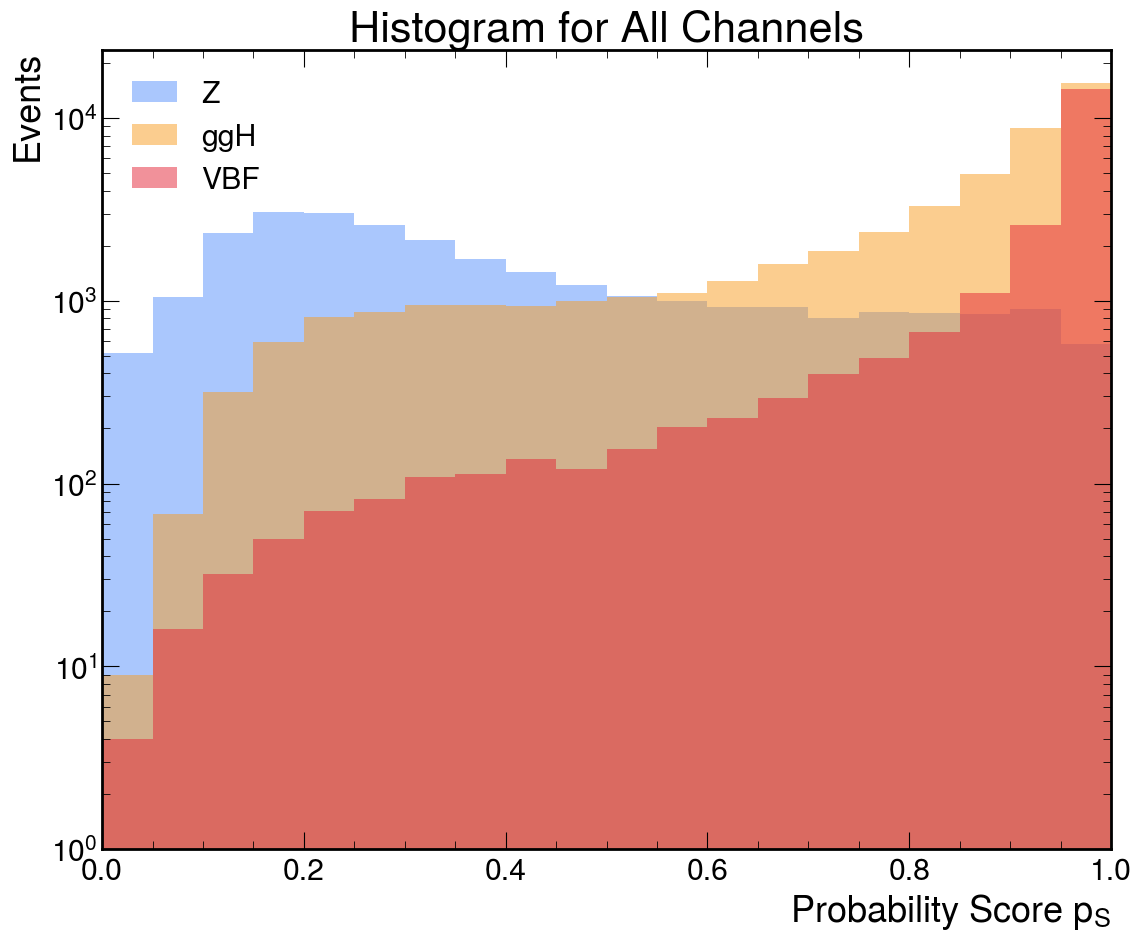

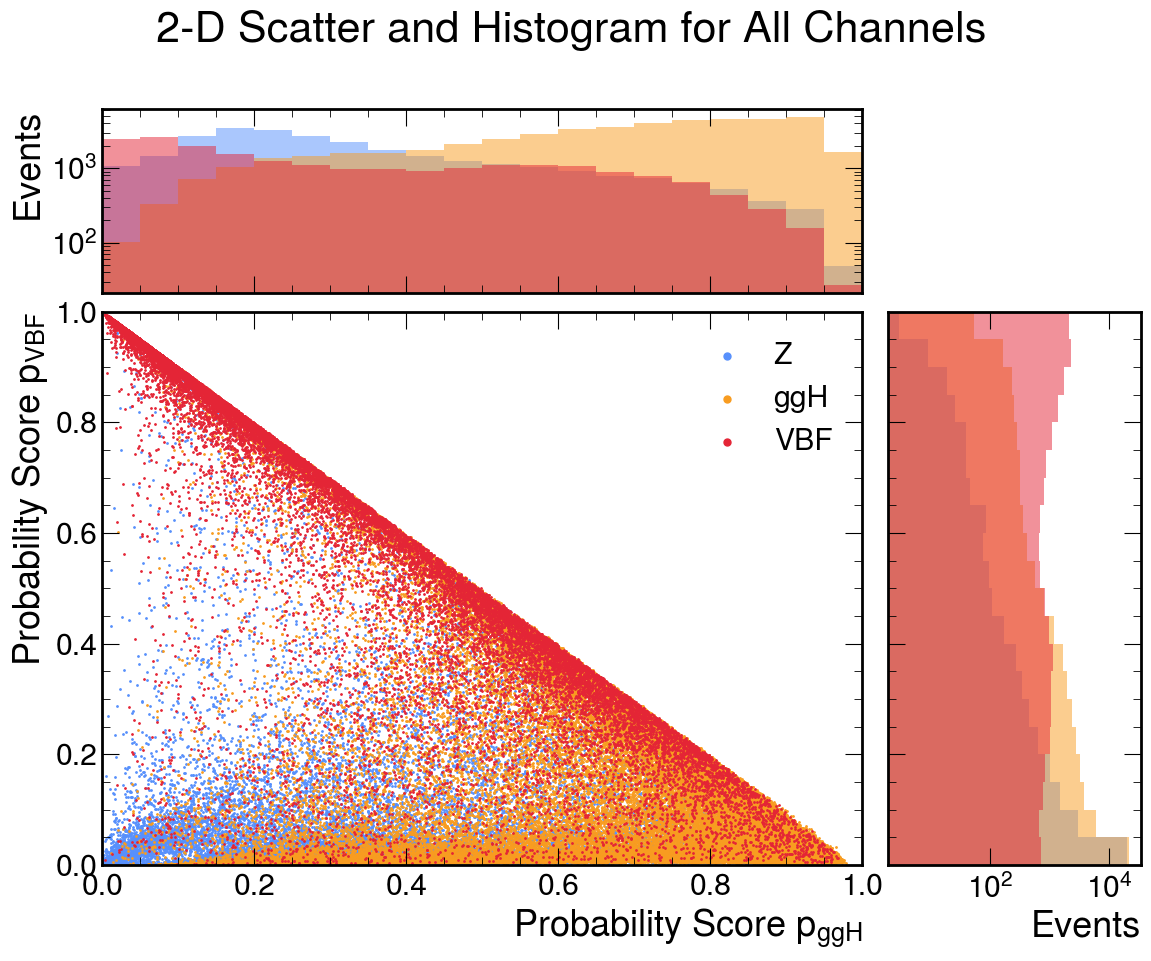

In [26]:
print(r"$\mu_{ggH} = %0.4f \pm %0.4f$" % (mu_total['ggH']['val'], mu_total['ggH']['err']))
print(r"$\mu_{VBF} = %0.4f \pm %0.4f$" % (mu_total['VBF']['val'], mu_total['VBF']['err']))
plot_multiclass_hist(scores_total['Z']['S'], scores_total['ggH']['S'], scores_total['VBF']['S'], bins=bins, channel='all')
plot_multiclass_hist2D(scores_total, channel='all', bins=bins)

In [27]:
scores_et, mu_et = multiclass_classification(dataset, channel='et', bins=bins)

[1/10] Channel Selection
[2/10] Concatenating Data
[3/10] Target Creation (Z=0, ggH=1, VBF=2)
[4/10] Train/Test Data Split
[5/10] Training XGBoost Multiclass Classifier
[6/10] Predicting Probabilities
[7/10] Building a Pseudo Signal Score and the Scores Dictionary
[8/10] Creating Histograms and Expected Counts Dictionary
[9/10] Fitting all the Signal Strength Parameters
[10/10] Preparing the mu dictionary


$\mu_{ggH,et} = 1.0000 \pm 0.0349$
$\mu_{VBF,et} = 1.0000 \pm 0.0968$


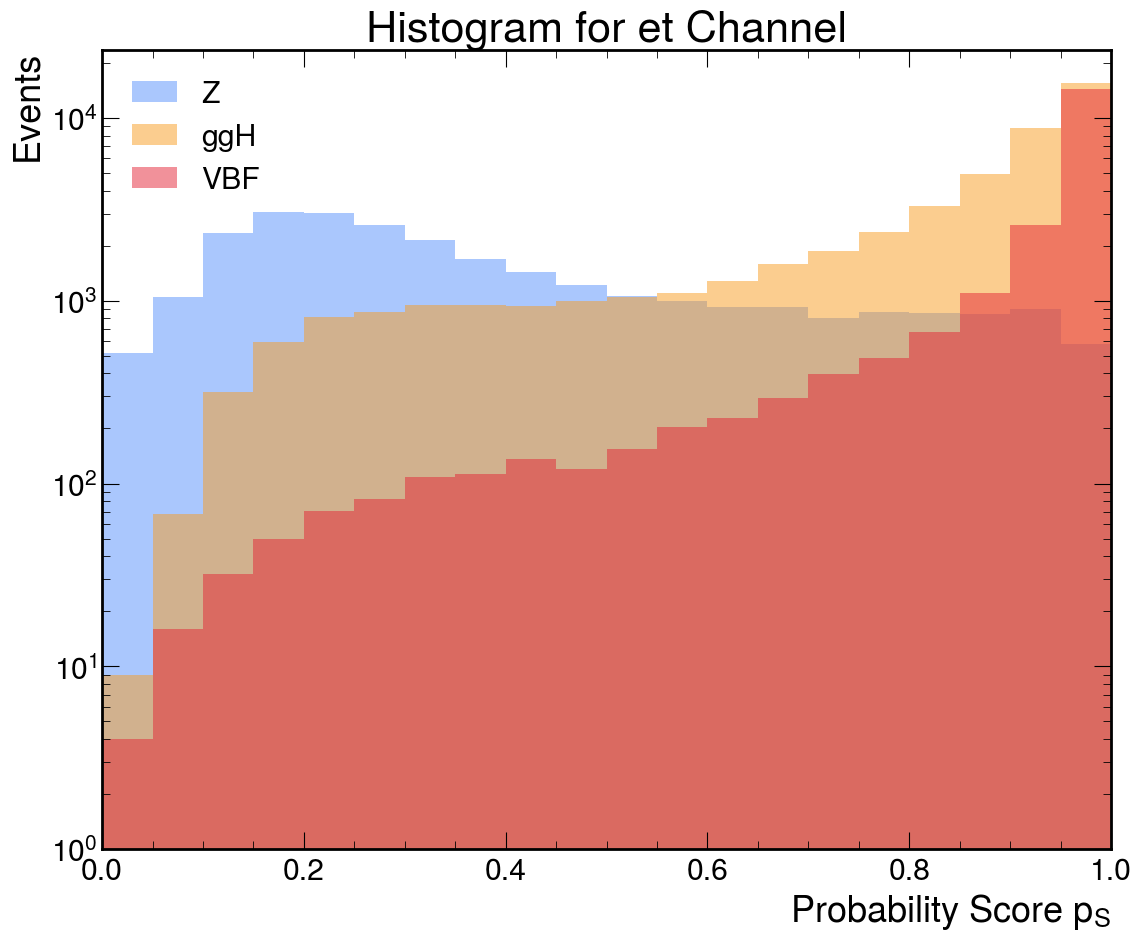

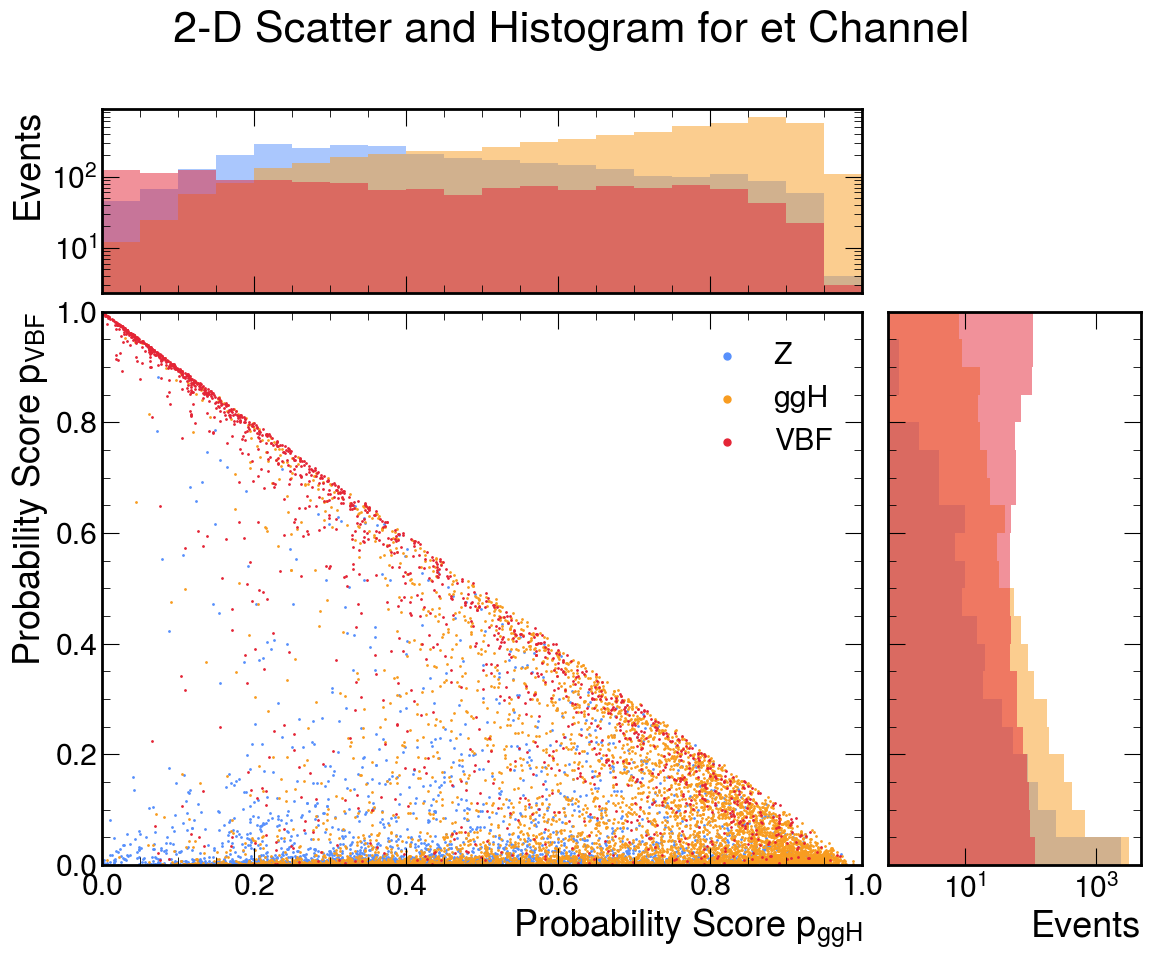

In [28]:
print(r"$\mu_{ggH,et} = %0.4f \pm %0.4f$" % (mu_et['ggH']['val'], mu_et['ggH']['err']))
print(r"$\mu_{VBF,et} = %0.4f \pm %0.4f$" % (mu_et['VBF']['val'], mu_et['VBF']['err']))
plot_multiclass_hist(scores_total['Z']['S'], scores_total['ggH']['S'], scores_total['VBF']['S'], bins=bins, channel='et')
plot_multiclass_hist2D(scores_et, channel='et', bins=bins)

In [29]:
scores_tt, mu_tt = multiclass_classification(dataset, channel='tt', bins=bins)

[1/10] Channel Selection
[2/10] Concatenating Data
[3/10] Target Creation (Z=0, ggH=1, VBF=2)
[4/10] Train/Test Data Split
[5/10] Training XGBoost Multiclass Classifier
[6/10] Predicting Probabilities
[7/10] Building a Pseudo Signal Score and the Scores Dictionary
[8/10] Creating Histograms and Expected Counts Dictionary
[9/10] Fitting all the Signal Strength Parameters
[10/10] Preparing the mu dictionary


$\mu_{ggH,tt} = 1.0000 \pm 0.0337$
$\mu_{VBF,tt} = 1.0000 \pm 0.0755$


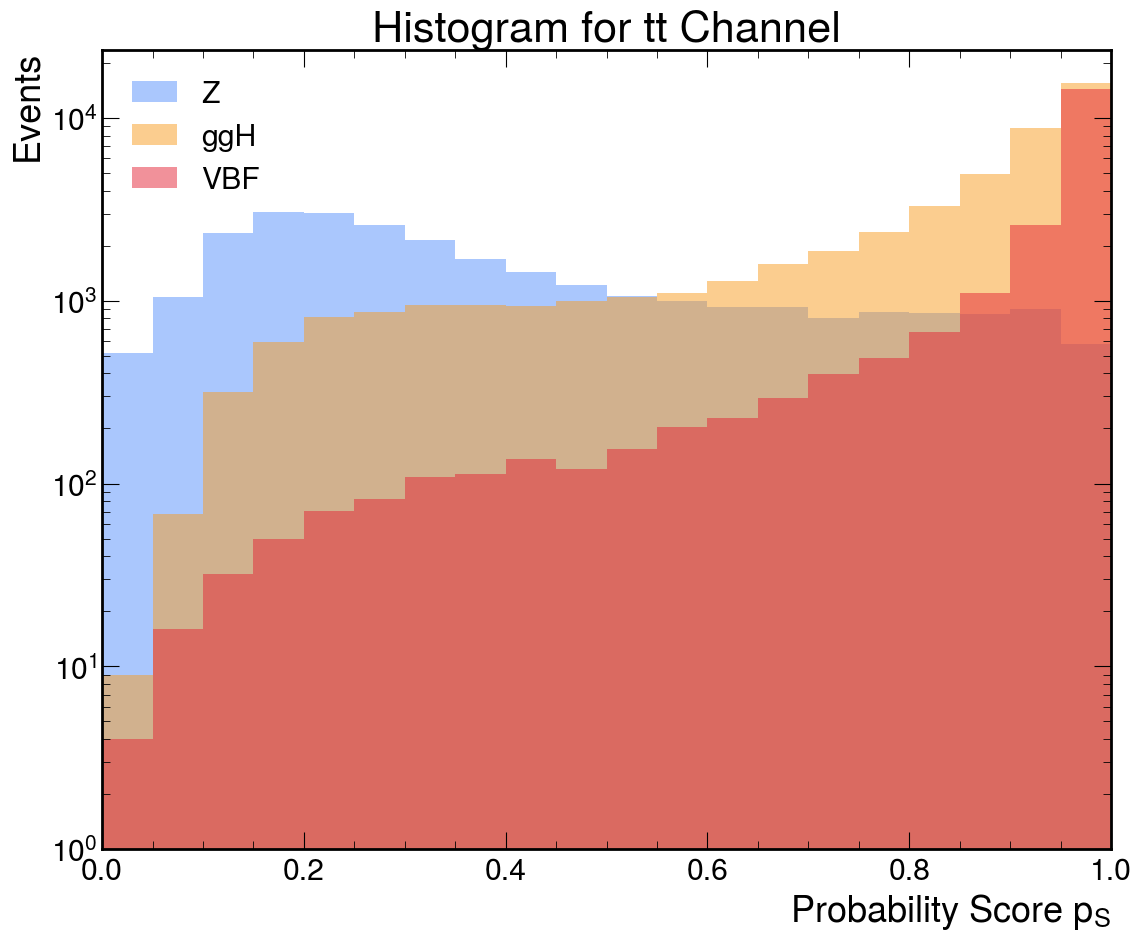

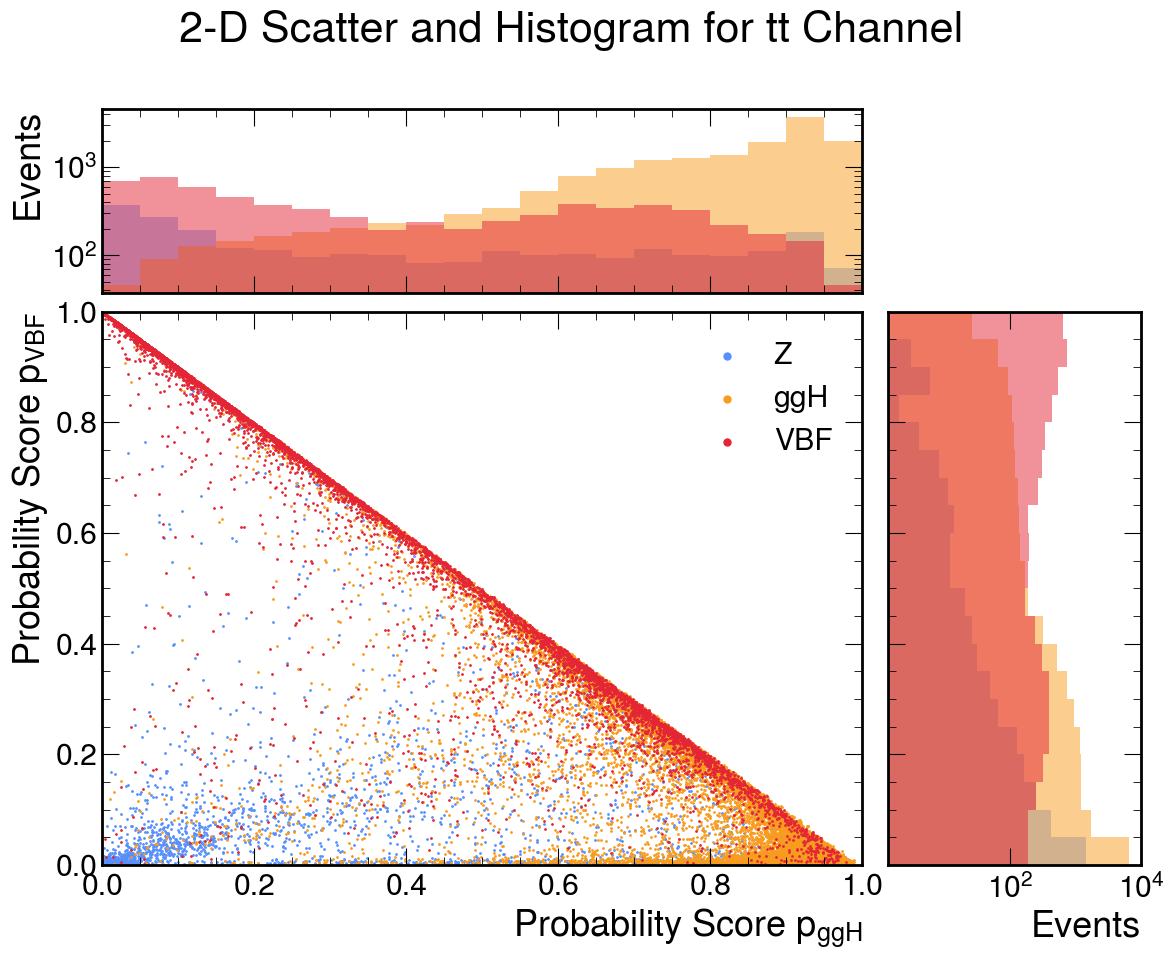

In [30]:
print(r"$\mu_{ggH,tt} = %0.4f \pm %0.4f$" % (mu_tt['ggH']['val'], mu_tt['ggH']['err']))
print(r"$\mu_{VBF,tt} = %0.4f \pm %0.4f$" % (mu_tt['VBF']['val'], mu_tt['VBF']['err']))
plot_multiclass_hist(scores_total['Z']['S'], scores_total['ggH']['S'], scores_total['VBF']['S'], bins=bins, channel='tt')
plot_multiclass_hist2D(scores_tt, channel='tt', bins=bins)

In [31]:
scores_mt, mu_mt = multiclass_classification(dataset, channel='mt', bins=bins)

[1/10] Channel Selection
[2/10] Concatenating Data
[3/10] Target Creation (Z=0, ggH=1, VBF=2)
[4/10] Train/Test Data Split
[5/10] Training XGBoost Multiclass Classifier
[6/10] Predicting Probabilities
[7/10] Building a Pseudo Signal Score and the Scores Dictionary
[8/10] Creating Histograms and Expected Counts Dictionary
[9/10] Fitting all the Signal Strength Parameters
[10/10] Preparing the mu dictionary


$\mu_{ggH,mt} = 1.0000 \pm 0.0161$
$\mu_{VBF,mt} = 1.0000 \pm 0.0251$


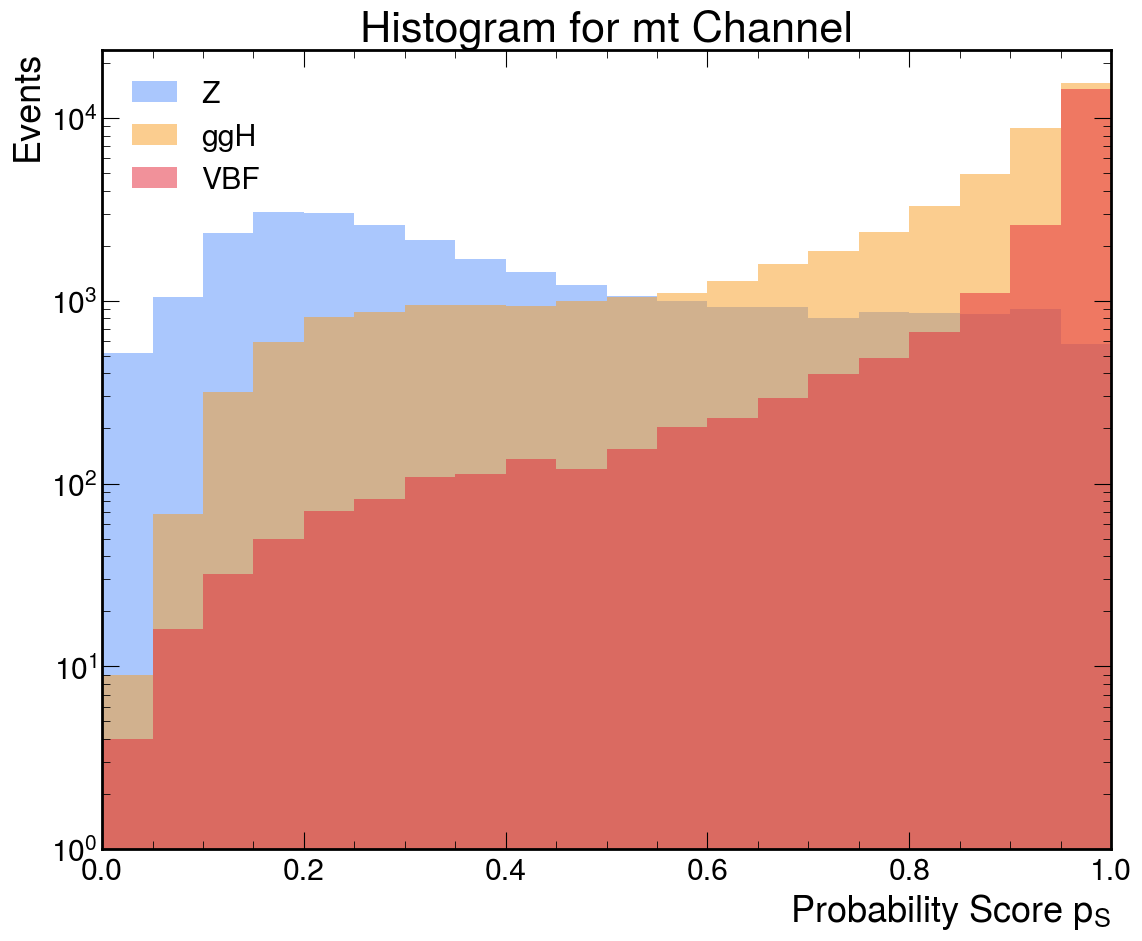

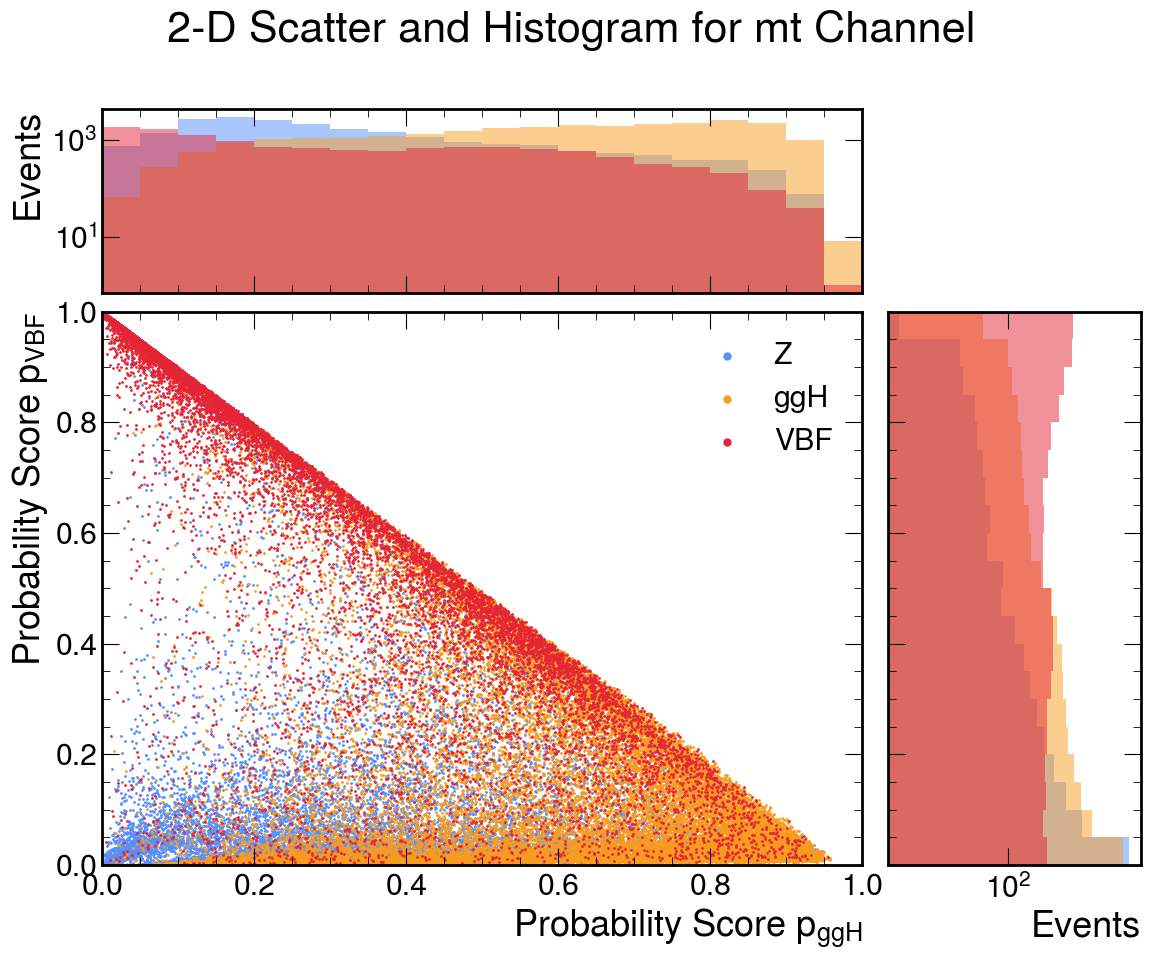

In [32]:
print(r"$\mu_{ggH,mt} = %0.4f \pm %0.4f$" % (mu_mt['ggH']['val'], mu_mt['ggH']['err']))
print(r"$\mu_{VBF,mt} = %0.4f \pm %0.4f$" % (mu_mt['VBF']['val'], mu_mt['VBF']['err']))
plot_multiclass_hist(scores_total['Z']['S'], scores_total['ggH']['S'], scores_total['VBF']['S'], bins=bins, channel='mt')
plot_multiclass_hist2D(scores_mt, channel='mt', bins=bins)


# ROUGH FOR TA ASK

In [ ]:
all_dfs = []
for channel in channels:
    for process in dataset[channel]:
        df = dataset[channel][process].copy()
        df['channel'] = channel
        df['process'] = process
        all_dfs.append(df)

data = pd.concat(all_dfs, ignore_index=True)

# Step 2: Create binary target
data['y'] = np.where(data['process'].isin(['ggH', 'VBF']), 1, 0)

# Step 3: Define features and target
X = data.drop(columns=['process', 'channel', 'y'])
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.125,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
plt.hist(y_pred_proba[y_test==0], bins=100, alpha=0.25, label='Background (Z)', color='red')
plt.hist(y_pred_proba[y_test==1], bins=100, alpha=0.25, label='Signal (S)', color='blue')
# plt.savefig('output.png')
plt.legend()
plt.show()

In [17]:
def nll_binary(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) assuming a single signal strength parameter
  for both ggH and VBF processes combined.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu (float): Signal strength multiplier applied to ggH and VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["H"]
  expected_counts = expected_counts_per_process["Z"] + mu * expected_counts_per_process["H"]
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

def nll_merge2(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) assuming a single signal strength parameter
  for both ggH and VBF processes combined.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu (float): Signal strength multiplier applied to ggH and VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z_o"] + expected_counts_per_process["H_o"]
  expected_counts = expected_counts_per_process["Z_e"] + mu * expected_counts_per_process["H_e"]
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

def nll_multi_merged(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) using separate signal strength parameters
  for ggH and VBF processes.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu_ggH (float): Signal strength multiplier for ggH.
    mu_VBF (float): Signal strength multiplier for VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + mu * (expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"])
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

def nll_multi_separate(expected_counts_per_process, mu_ggH, mu_VBF):
  """
  Compute the negative log-likelihood (NLL) using separate signal strength parameters
  for ggH and VBF processes.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu_ggH (float): Signal strength multiplier for ggH.
    mu_VBF (float): Signal strength multiplier for VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu_ggH * expected_counts_per_process["ggH"]) + (mu_VBF * expected_counts_per_process["VBF"])
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

In [ ]:
Z_e_scores = y_pred_proba[y_test==0]
H_e_scores = y_pred_proba[y_test==1]
Z_o_scores = y_test[y_test==0]
H_o_scores = y_test[y_test==1]

bin_edges = np.linspace(0, 1, 51)
hist_Z_o, _   = np.histogram(Z_o_scores,   bins=bin_edges)
hist_H_o, _   = np.histogram(H_o_scores,   bins=bin_edges)
hist_Z_e, _   = np.histogram(Z_e_scores,   bins=bin_edges)
hist_H_e, _   = np.histogram(H_e_scores,   bins=bin_edges)

expected_counts_per_process = {
    "Z_o": hist_Z_o,
    "H_o": hist_H_o,
    "Z_e": hist_Z_e,
    "H_e": hist_H_e
}

nll = partial(nll_merge2, expected_counts_per_process)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

plt.hist(Z_e_scores, bins=100, alpha=0.5, label='Background (Z)', color='red')
plt.hist(H_e_scores, bins=100, alpha=0.5, label='Signal (H)', color='blue')
plt.show()